# Stock Price Prediction - Microsoft

**Table of contents**<a id='toc0_'></a>    
- 1. [Problem Definition](#toc1_)    
- 2. [Getting Started](#toc2_)    
  - 2.1. [Load Libraries](#toc2_1_)    
  - 2.2. [Load Dataset](#toc2_2_)    
- 3. [Exploratory Data Analysis](#toc3_)    
  - 3.1. [Descriptive Statistics](#toc3_1_)    
  - 3.2. [Data Visualisation](#toc3_2_)    
  - 3.3. [Time Series Analysis](#toc3_3_)    
- 4. [Data Preparation](#toc4_)    
  - 4.1. [Data Cleaning](#toc4_1_)    
  - 4.2. [Feature Selection](#toc4_2_)    
- 5. [Evaluate Algorithms and Models](#toc5_)    
  - 5.1. [Train/Test Split](#toc5_1_)    
  - 5.2. [Evaluation Metrics](#toc5_2_)    
  - 5.3. [Compare Models and Algorithms](#toc5_3_)    
    - 5.3.1. [Machine Learning models-scikit-learn](#toc5_3_1_)    
    - 5.3.2. [Time Series based Models-ARIMA and LSTM](#toc5_3_2_)    
- 6. [Model Tuning and Grid Search](#toc6_)    
- 7. [Finalise the model](#toc7_)    
  - 7.1. [Result on the test dataset](#toc7_1_)    
  - 7.2. [Save Model for Later Use](#toc7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Problem Definition](#toc0_)

## 2. <a id='toc2_'></a>[Getting Started](#toc0_)

In [39]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

### 2.1. <a id='toc2_1_'></a>[Load Libraries](#toc0_)

In [40]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
#from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump, load

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

#Yahoo Finance Open source API
import yfinance as yf

### 2.2. <a id='toc2_2_'></a>[Load Dataset](#toc0_)

In [41]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = yf.download(stk_tickers, auto_adjust=False)
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

[*********************100%***********************]  3 of 3 completed


In [42]:
return_period = 5

## 3. <a id='toc3_'></a>[Exploratory Data Analysis](#toc0_)

In [43]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

### 3.1. <a id='toc3_1_'></a>[Descriptive Statistics](#toc0_)

In [44]:
pd.set_option('display.precision', 3)  # Correto
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,235.000,235.000,235.000,235.000,2.350e+02,235.000,235.000,235.000,235.000,235.000,235.000,235.000
mean,0.005,0.004,0.006,0.002,-1.508e-04,0.004,0.003,-0.004,0.004,0.012,0.022,0.048
std,0.034,0.040,0.035,0.013,1.251e-02,0.025,0.025,0.143,0.033,0.061,0.078,0.102
min,-0.078,-0.119,-0.125,-0.042,-6.616e-02,-0.082,-0.082,-0.542,-0.078,-0.240,-0.299,-0.246
25%,-0.018,-0.020,-0.013,-0.005,-6.999e-03,-0.009,-0.011,-0.097,-0.017,-0.023,-0.031,-0.019
50%,0.004,0.006,0.005,0.001,-5.589e-04,0.004,0.002,-0.008,0.005,0.016,0.025,0.047
75%,0.027,0.028,0.025,0.009,7.294e-03,0.017,0.017,0.081,0.026,0.049,0.082,0.120
max,0.164,0.115,0.175,0.053,7.540e-02,0.160,0.183,0.532,0.164,0.245,0.207,0.293


In [45]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2020-03-23,0.164,-1.774e-02,-0.044,0.053,-0.066,-0.064,-0.082,-0.295,0.004,-0.240,-0.299,-1.434e-01
2020-03-30,0.031,8.383e-02,0.175,-0.030,0.075,0.160,0.183,-0.076,0.164,0.062,-0.143,2.966e-04
2020-04-06,0.050,3.167e-02,0.017,0.010,-0.008,0.014,0.016,-0.232,0.031,0.199,-0.033,2.216e-02
2020-04-14,-0.034,6.704e-02,0.076,-0.017,0.022,0.068,0.056,-0.212,0.050,0.245,0.005,4.705e-02
2020-04-22,0.022,8.825e-04,0.005,0.004,-0.015,0.006,-0.001,0.028,0.009,0.096,0.075,6.970e-02


### 3.2. <a id='toc3_2_'></a>[Data Visualisation](#toc0_)

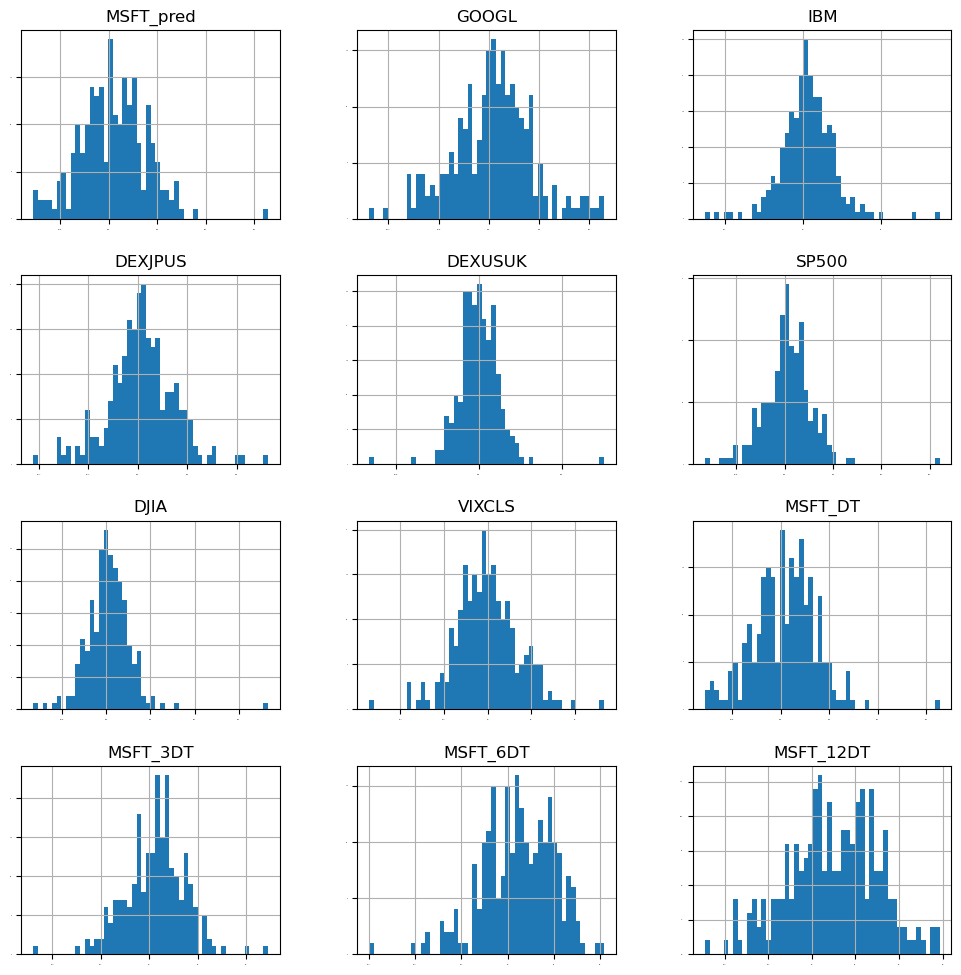

In [46]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

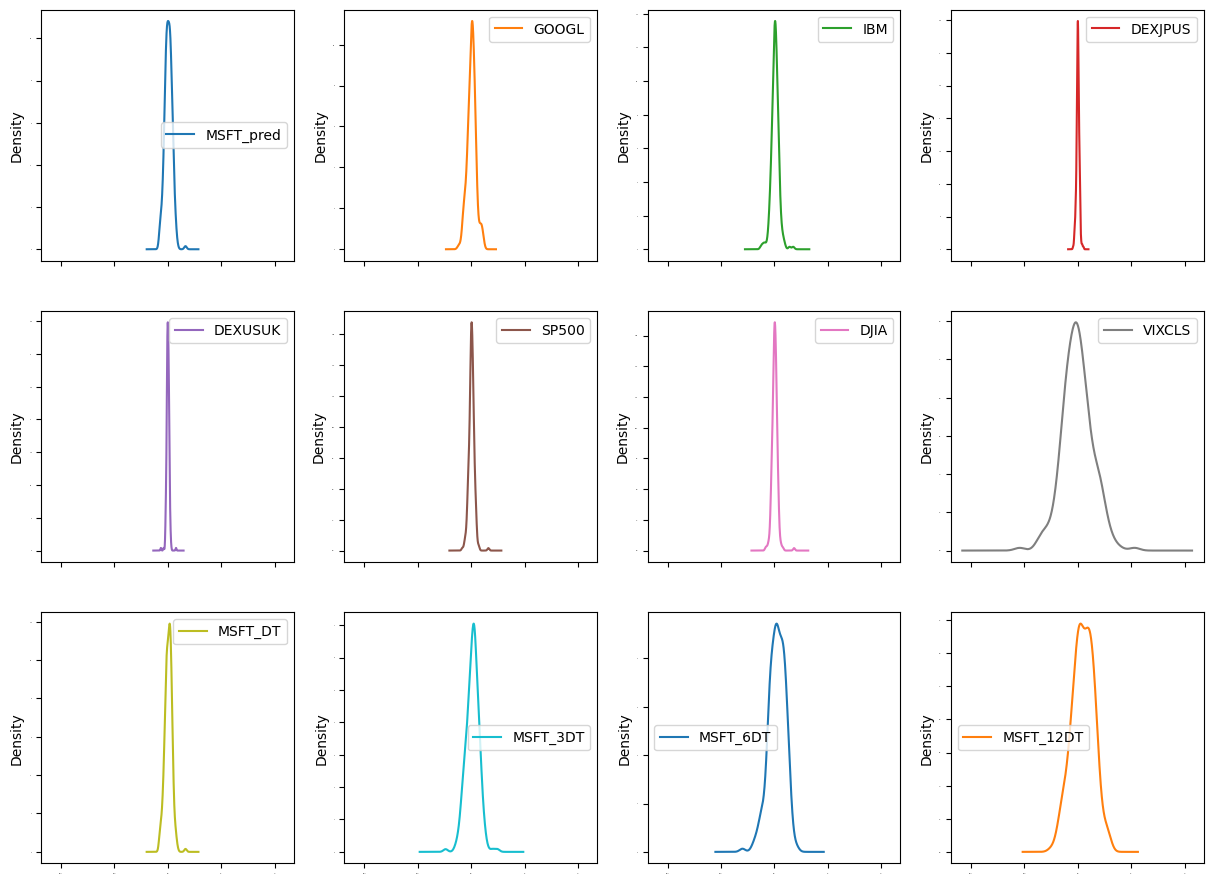

In [47]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

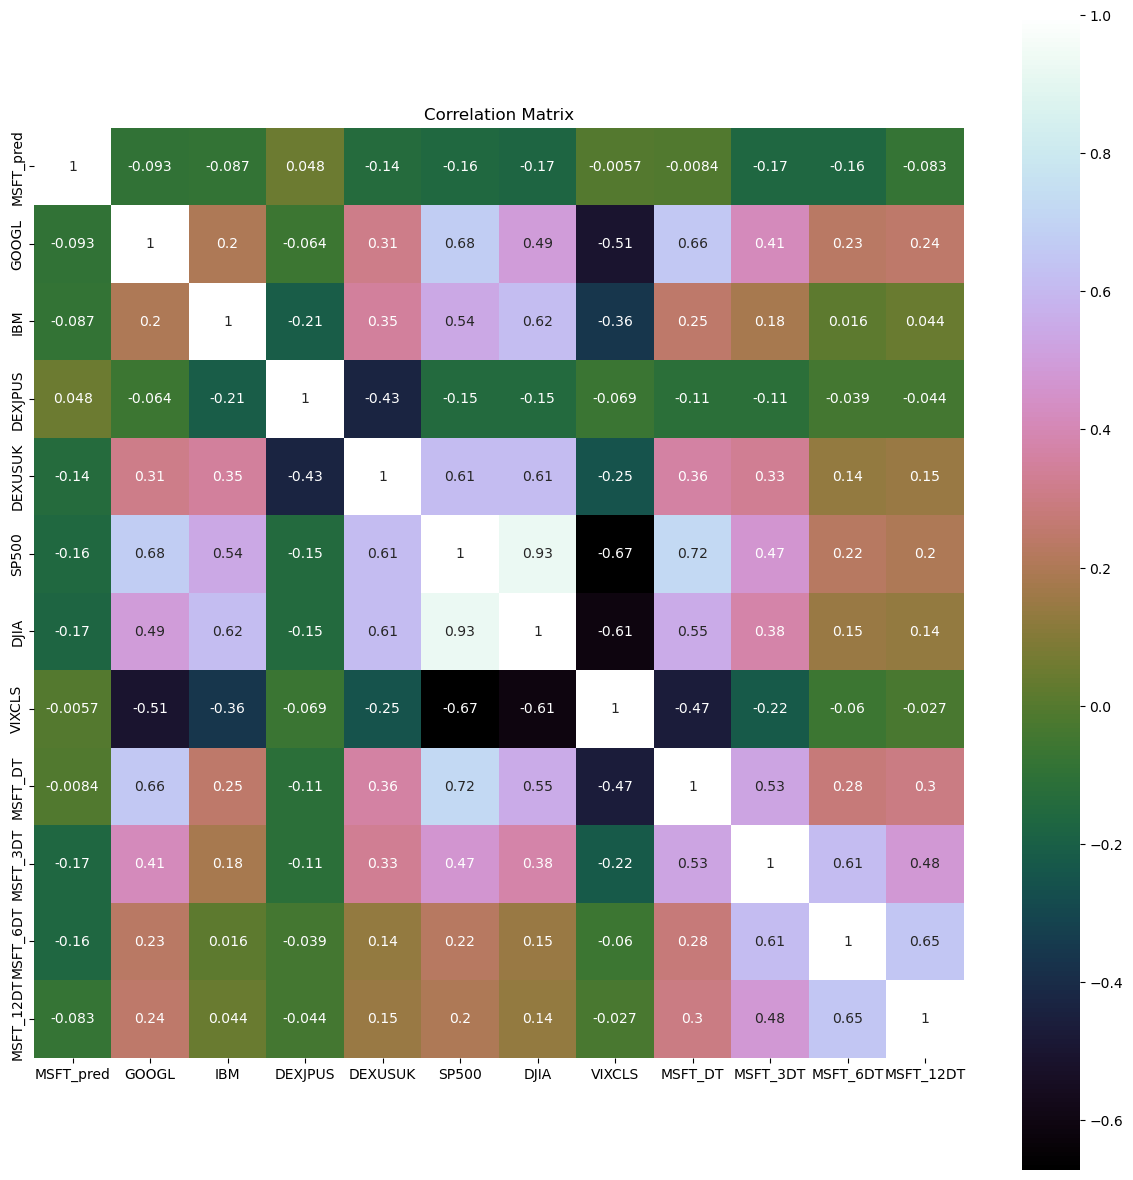

In [48]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

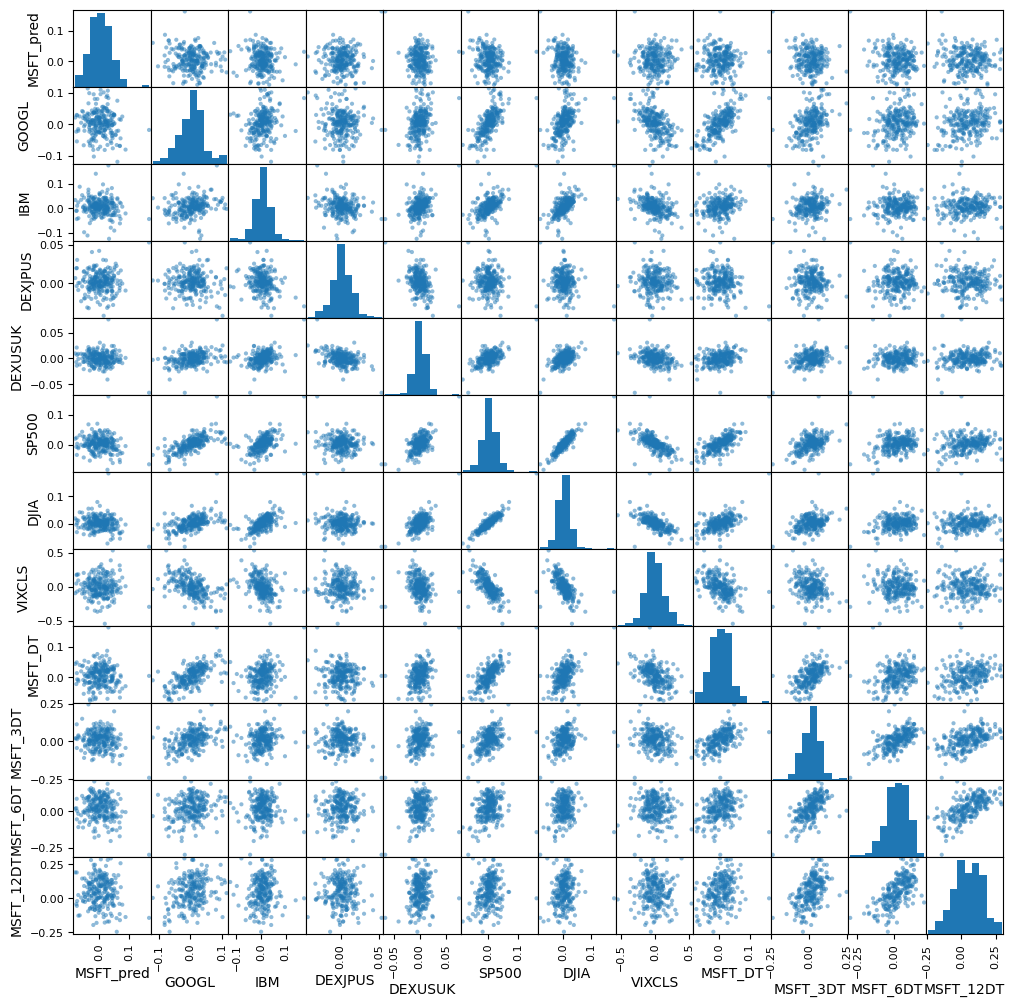

In [49]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

### 3.3. <a id='toc3_3_'></a>[Time Series Analysis](#toc0_)

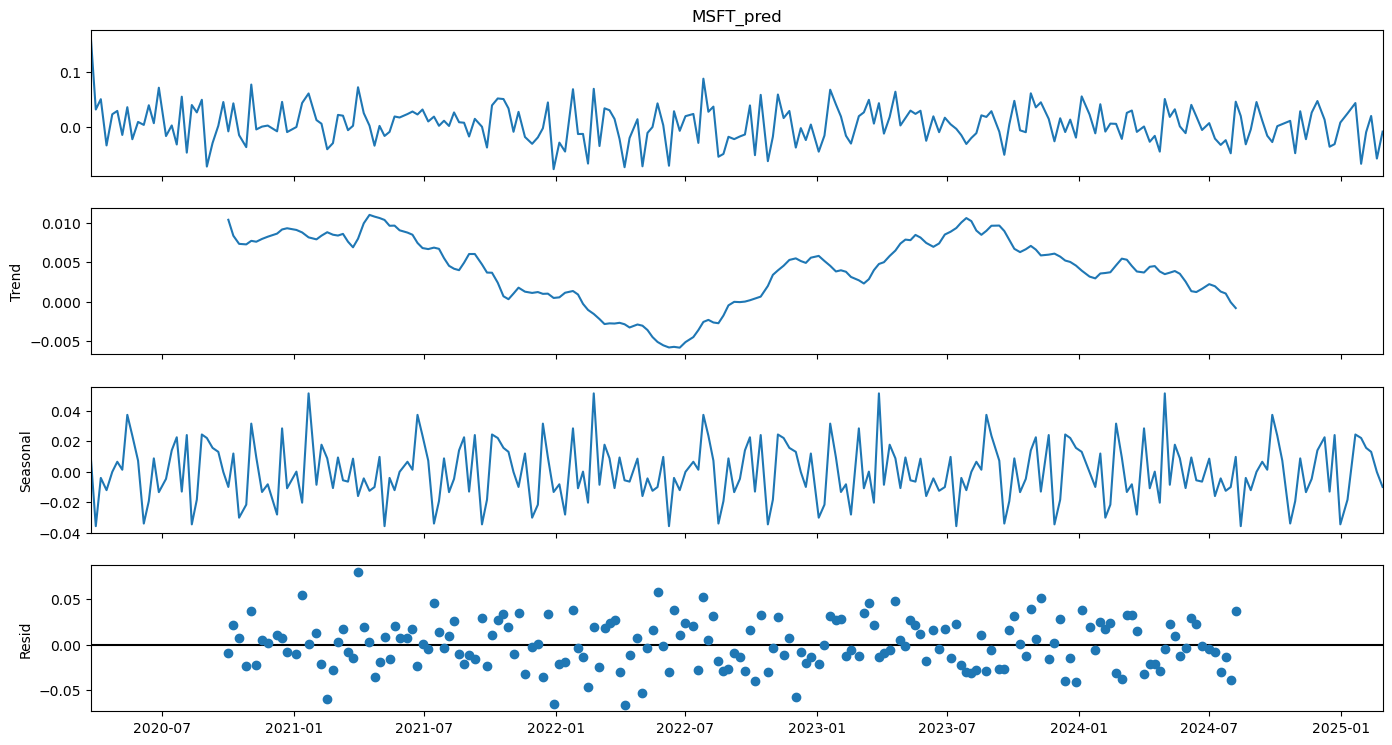

In [50]:
res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

## 4. <a id='toc4_'></a>[Data Preparation](#toc0_)

In [51]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
DJIA,7.209
MSFT_3DT,6.597
MSFT_6DT,6.483
SP500,5.865
DEXUSUK,4.541
GOOGL,2.024
IBM,1.766
MSFT_12DT,1.600
DEXJPUS,0.538


### 4.1. <a id='toc4_1_'></a>[Data Cleaning](#toc0_)

### 4.2. <a id='toc4_2_'></a>[Feature Selection](#toc0_)

## 5. <a id='toc5_'></a>[Evaluate Algorithms and Models](#toc0_)

### 5.1. <a id='toc5_1_'></a>[Train/Test Split](#toc0_)

In [52]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

### 5.2. <a id='toc5_2_'></a>[Test Options and Evaluation Metrics](#toc0_)

In [53]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

### 5.3. <a id='toc5_3_'></a>[Compare Models and Algorithms](#toc0_)

#### 5.3.1. <a id='toc5_3_1_'></a>[Machine Learning models-scikit-learn](#toc0_)

Regression and Tree Regression Algorithms

In [54]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

Neural Network Algorithms


In [55]:
models.append(('MLP', MLPRegressor()))

Ensable Models

In [56]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. First we run the K-fold analysis. Next we run the model on the entire training and testing dataset.

In [57]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001264 (0.000566) 0.001095 0.000879
LASSO: 0.001242 (0.000588) 0.001226 0.000947
EN: 0.001242 (0.000588) 0.001226 0.000947
KNN: 0.001437 (0.000538) 0.000942 0.000899
CART: 0.002375 (0.001073) 0.000000 0.001629
SVR: 0.001772 (0.000896) 0.001664 0.001704
MLP: 0.002110 (0.001212) 0.001257 0.001006
ABR: 0.001377 (0.000588) 0.000707 0.000932
GBR: 0.001737 (0.000800) 0.000121 0.000815
RFR: 0.001324 (0.000527) 0.000179 0.000895
ETR: 0.001293 (0.000478) 0.000000 0.000942


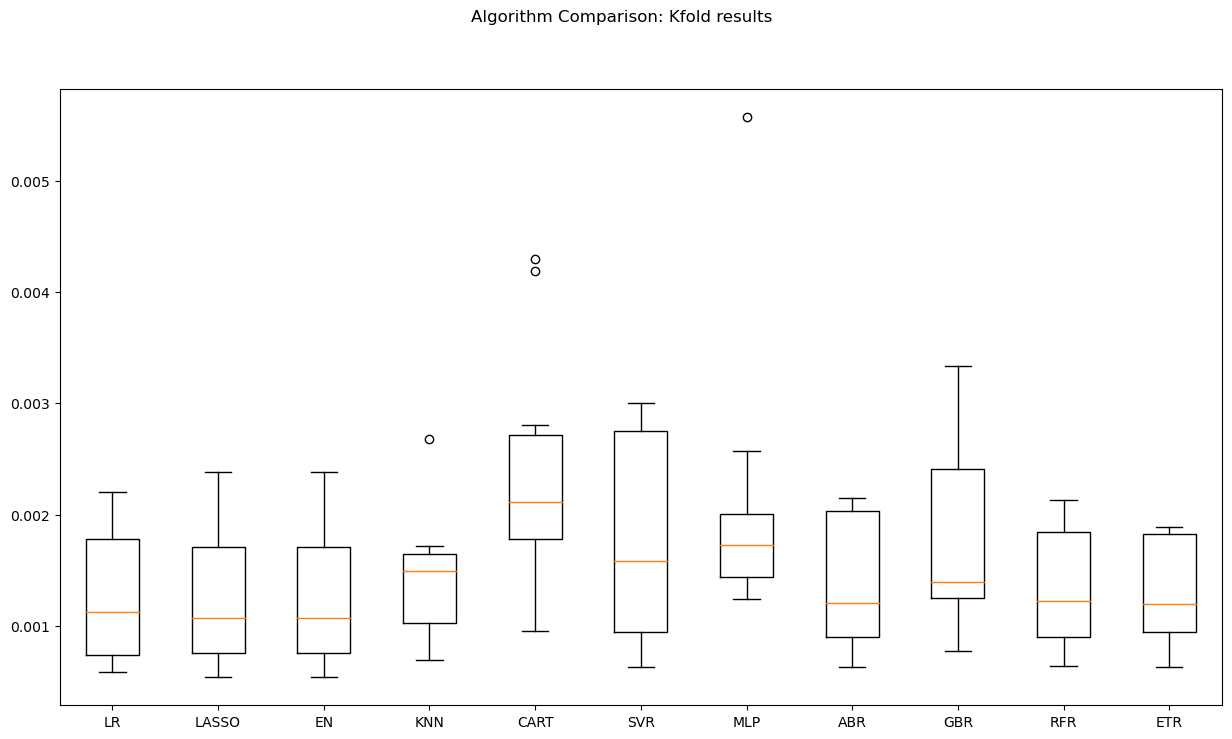

In [58]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

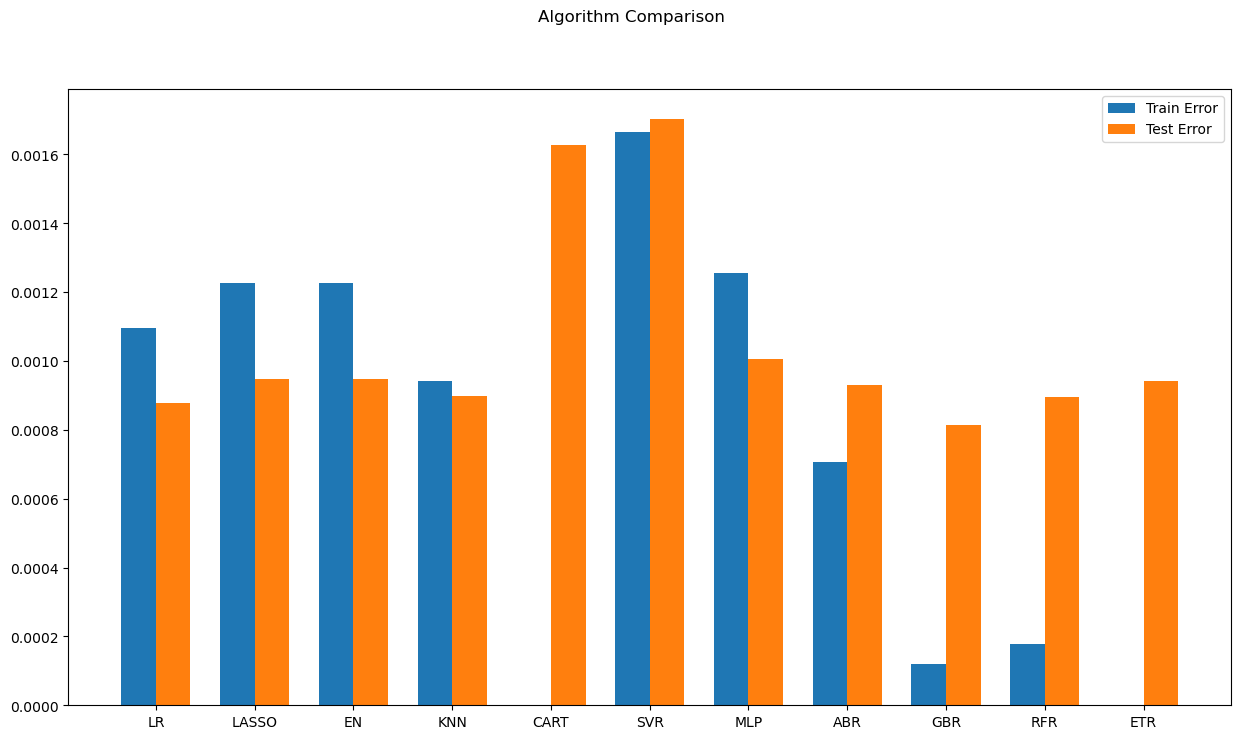

In [59]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

#### 5.3.2. <a id='toc5_3_2_'></a>[Time Series based Models-ARIMA and LSTM](#toc0_)

In [60]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [61]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [62]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0009777664202625387

In [63]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [64]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0.0):
        # create model
    model = Sequential()
    model.add(LSTM(50))#, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(learning_rate=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer=optimizer)
    return model

LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0.0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

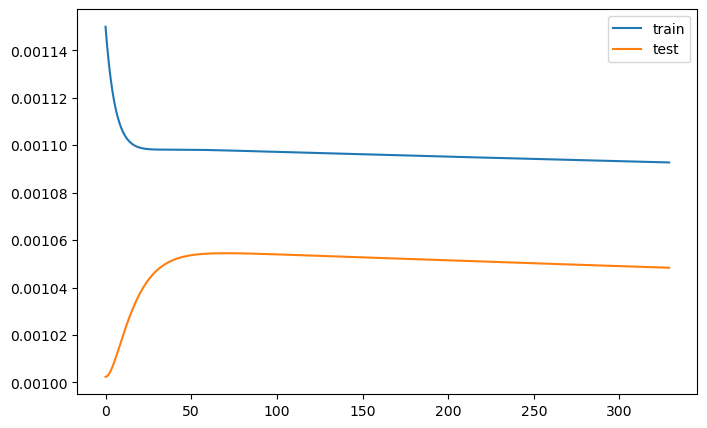

In [65]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [66]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

2/2 [==============================] - 0s 4ms/step


In [67]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

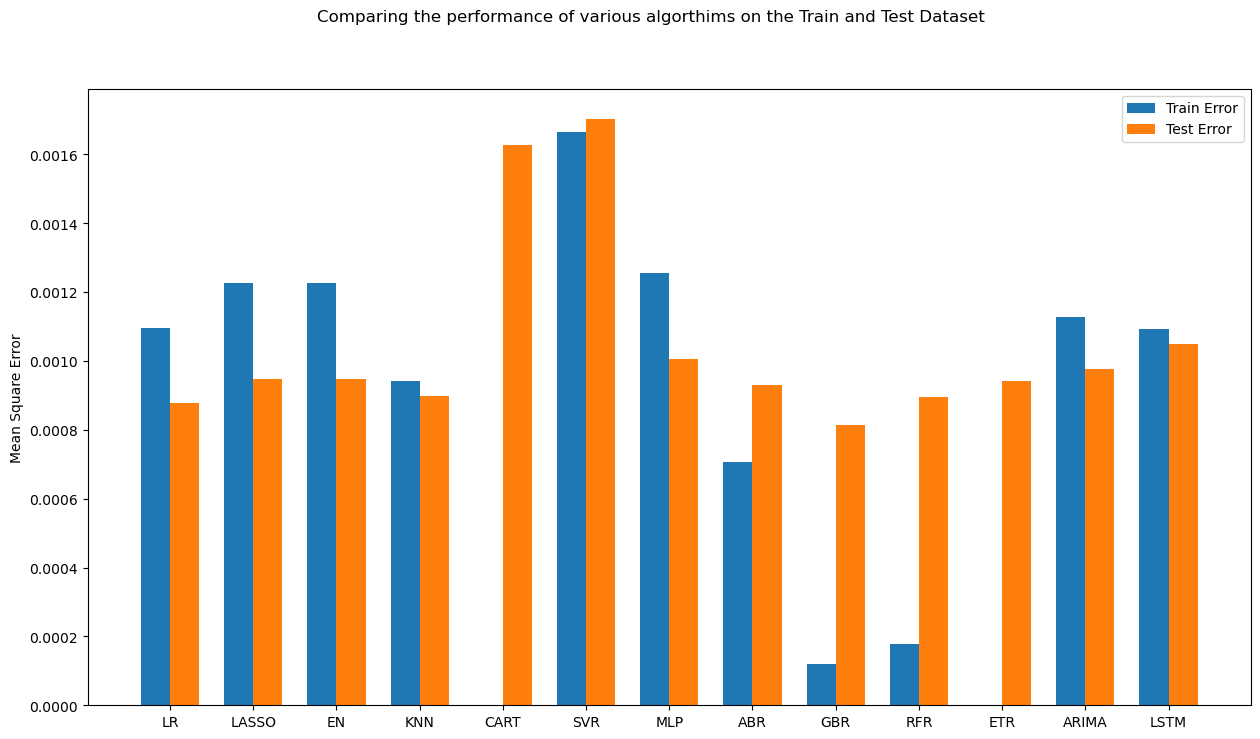

In [68]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

## 6. <a id='toc6_'></a>[Model Tuning and Grid Search](#toc0_)

In [69]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

ARIMA(0, 0, 0) MSE=0.0011521
ARIMA(0, 0, 1) MSE=0.0011336
ARIMA(0, 1, 0) MSE=0.0017070
ARIMA(0, 1, 1) MSE=0.0012684
ARIMA(1, 0, 0) MSE=0.0011282
ARIMA(1, 0, 1) MSE=0.0011299
ARIMA(1, 1, 0) MSE=0.0015663
ARIMA(1, 1, 1) MSE=0.0012516
ARIMA(2, 0, 0) MSE=0.0011279
ARIMA(2, 0, 1) MSE=0.0011282
ARIMA(2, 1, 0) MSE=0.0015209
ARIMA(2, 1, 1) MSE=0.0012512
Best ARIMA(2, 0, 0) MSE=0.0011279


## 7. <a id='toc7_'></a>[Finalise the model](#toc0_)

### 7.1. <a id='toc7_1_'></a>[Result on the test dataset](#toc0_)

In [70]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,0])
model_fit_tuned = modelARIMA_tuned.fit()

In [71]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0009777664202625387


### 7.2. <a id='toc7_2_'></a>[Save Model for Later Use](#toc0_)

In [72]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = '../_models/microsoft-stock-price.sav'
dump(model_fit_tuned, open(filename, 'wb'))

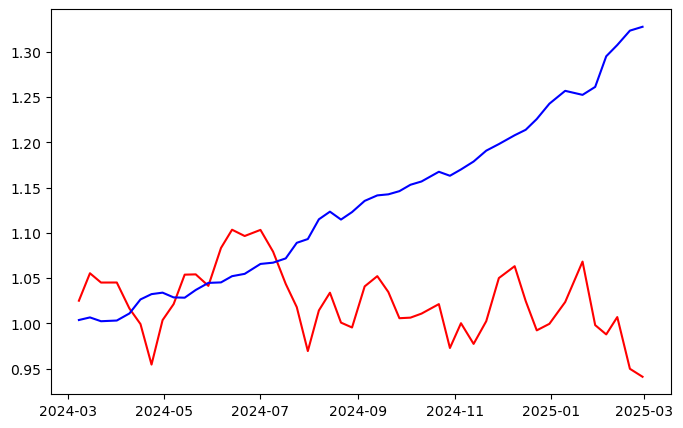

In [73]:
#Use the following code to produce the comparison of actual vs. predicted
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()